# Kaggle Titanic

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


## What Data Will I Use in This Competition?

In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

In [121]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
from tensorflow import keras

Let's load the training and test data set and take a look at it.

In [122]:
train_data = pd.read_csv("train.csv", index_col = 0)
test_data = pd.read_csv("test.csv", index_col = 0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Columns

Here are the different columns in the data set and what they represent

| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes

pclass: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.


## Data Preprocessing

Let's process the data in our training set and turn them into numpy arrays that TensorFlow can handle.

First, let's extract the Survived column from the train data and create our training targets. 



In [123]:
# Extract the ground truth targets from the train data. 
train_targets = train_data["Survived"].to_numpy()

# Remove targets from the train data
train_data.drop(columns=["Survived"], inplace=True)



### Pclass

Let's examine the `Pclass` column.

First, check to see if there are any missing values.

In [124]:
def has_missing_values(series):
    if series.isnull().values.any():
        print(f"{series.name} HAS MISSING VALUES.")
    else:
        print(f"{series.name} does not have any missing values.")

In [125]:
has_missing_values(train_data["Pclass"])

Pclass does not have any missing values.


Great. Looks like Pclass does not have any missing values. It seems that all of the values in `Pclass` are integers, but let's double check.

In [126]:
def list_unique_values_in_series(series):
    # Print a unique list of all values in the given pd.Series
    print(f"Unique values in {series.name} column: {list(series.unique())}") 

In [127]:
list_unique_values_in_series(train_data['Pclass'])

Unique values in Pclass column: [3, 1, 2]


I now know that Pclass has no missing values, and only contains the integers 1, 2, and 3. 

I will come back to normalize these values at the end. As of now, let's move on to the next column.

### Name

The name of each passenger will be hard to process. For now, let's completely ignore the passengers name and see what kind of results we get. 

For future implementions, I might try to one-hot encode the last name, as it could be possible that we can find relations between people with the same last name.

In [128]:
# Remove Name from the data sets
train_data.drop(columns=["Name"], inplace=True)
test_data.drop(columns=["Name"], inplace=True)

### Sex

Let's check to see if there are any missing or odd values

In [129]:
has_missing_values(train_data["Sex"])
list_unique_values_in_series(train_data['Sex'])

Sex does not have any missing values.
Unique values in Sex column: ['male', 'female']


Excelent. No missing values. Let's encode these to binary values, 0 and 1. 

female -> 0

male -> 1

In [130]:
# Replace all the "female" values with 0, and all the "male" values with 1.
train_data["Sex"].replace(["female", "male"], [0, 1], inplace = True)
test_data["Sex"].replace(["female", "male"], [0, 1], inplace = True)

### Age

Let's examine the Age column

In [131]:
has_missing_values(train_data["Age"])
list_unique_values_in_series(train_data['Age'])

Age HAS MISSING VALUES.
Unique values in Age column: [22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0, 14.0, 4.0, 58.0, 20.0, 39.0, 55.0, 31.0, 34.0, 15.0, 28.0, 8.0, 19.0, 40.0, 66.0, 42.0, 21.0, 18.0, 3.0, 7.0, 49.0, 29.0, 65.0, 28.5, 5.0, 11.0, 45.0, 17.0, 32.0, 16.0, 25.0, 0.83, 30.0, 33.0, 23.0, 24.0, 46.0, 59.0, 71.0, 37.0, 47.0, 14.5, 70.5, 32.5, 12.0, 9.0, 36.5, 51.0, 55.5, 40.5, 44.0, 1.0, 61.0, 56.0, 50.0, 36.0, 45.5, 20.5, 62.0, 41.0, 52.0, 63.0, 23.5, 0.92, 43.0, 60.0, 10.0, 64.0, 13.0, 48.0, 0.75, 53.0, 57.0, 80.0, 70.0, 24.5, 6.0, 0.67, 30.5, 0.42, 34.5, 74.0]


So it turns out that our Age column has some missing values. 

One options is to remove the missing values, but then we would be losing out on data, and if our test data happens to have missing values, we would have to figure out a way to handle these anyways.

Let's instead replace any missing value with the average age of all passengers aboard.

In [132]:
mean_passenger_age = train_data["Age"].mean(axis=0)
print(mean_passenger_age)

29.69911764705882


In [133]:
# Fill in all missing age values with the mean passenger age
train_data["Age"].fillna(value = mean_passenger_age, inplace=True)
test_data["Age"].fillna(value = mean_passenger_age, inplace=True)

has_missing_values(train_data["Age"])

Age does not have any missing values.


### Sibsp: Number of siblings or spouses aboard

The values of this column should be an integer number.

It looks like there are no mising values here.

In [134]:
has_missing_values(train_data["SibSp"])
list_unique_values_in_series(train_data["SibSp"])

SibSp does not have any missing values.
Unique values in SibSp column: [1, 0, 3, 4, 2, 5, 8]


### Parch: Number of parents or children aboard

The values of this column should be an integer number.

It looks like there are no mising values here.

In [135]:
has_missing_values(train_data["Parch"])
list_unique_values_in_series(train_data["Parch"])

Parch does not have any missing values.
Unique values in Parch column: [0, 1, 2, 5, 3, 4, 6]


# Ticket

This column describes the ticket number for each passenger. There are almost as many ticket numbers as there are passengers, and they all have different formats too. Let's omit this for now. 

One way to handle this column would be to see if some of the prefix letters are some identifying ticket info, aside from the number. 

In [136]:
# Remove Ticket number from the data sets
train_data.drop(columns=["Ticket"], inplace=True)
test_data.drop(columns=["Ticket"], inplace=True)

### Fare 

This should be the cost each passenger paid for their ticket. 

In [137]:
has_missing_values(train_data["Fare"])
list_unique_values_in_series(train_data["Fare"])

Fare does not have any missing values.
Unique values in Fare column: [7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51.8625, 21.075, 11.1333, 30.0708, 16.7, 26.55, 31.275, 7.8542, 16.0, 29.125, 13.0, 18.0, 7.225, 26.0, 8.0292, 35.5, 31.3875, 263.0, 7.8792, 7.8958, 27.7208, 146.5208, 7.75, 10.5, 82.1708, 52.0, 7.2292, 11.2417, 9.475, 21.0, 41.5792, 15.5, 21.6792, 17.8, 39.6875, 7.8, 76.7292, 61.9792, 27.75, 46.9, 80.0, 83.475, 27.9, 15.2458, 8.1583, 8.6625, 73.5, 14.4542, 56.4958, 7.65, 29.0, 12.475, 9.0, 9.5, 7.7875, 47.1, 15.85, 34.375, 61.175, 20.575, 34.6542, 63.3583, 23.0, 77.2875, 8.6542, 7.775, 24.15, 9.825, 14.4583, 247.5208, 7.1417, 22.3583, 6.975, 7.05, 14.5, 15.0458, 26.2833, 9.2167, 79.2, 6.75, 11.5, 36.75, 7.7958, 12.525, 66.6, 7.3125, 61.3792, 7.7333, 69.55, 16.1, 15.75, 20.525, 55.0, 25.925, 33.5, 30.6958, 25.4667, 28.7125, 0.0, 15.05, 39.0, 22.025, 50.0, 8.4042, 6.4958, 10.4625, 18.7875, 31.0, 113.275, 27.0, 76.2917, 90.0, 9.35, 13.5, 7.55, 26.25, 12.275, 7.125, 52.5542, 20.

It seems that there are no missing values, but there are some zeroes. Perhaps some passengers did get free tickets, but let's check how many to make sure it doesn't obscure our data by too much.

It seems that only 15 of the passengers has a $0 fare, which is small enough that it seems valid. 

In [138]:
print(train_data["Fare"].value_counts())
print(f'Number of passengers with $0 fare: {train_data["Fare"].value_counts()[0]}')

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64
Number of passengers with $0 fare: 15


### Cabin Number

It appears that there are some missing data points. 


In [139]:
has_missing_values(train_data["Cabin"])
list_unique_values_in_series(train_data["Cabin"])
print(f'Number of missing cabin number values: {train_data["Cabin"].isnull().sum()}')

Cabin HAS MISSING VALUES.
Unique values in Cabin column: [nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24', 'C90', 'C45', 'E8', 'B101', 'D45', 'C46

It turns out that there are a lot of missing data points. However, we still have a fair amount of good values. 

It appears that most cabin numbers are in the form of a letter then a number. I will assume that the letter has more importance, so let's consider the first character of each Cabin number only.



In [140]:
# Fill missing values with zero
train_data["Cabin"].fillna(value = "0", inplace=True)
test_data["Cabin"].fillna(value = "0", inplace=True)

# Concatenate the values, then replace using dictionary
cabin_replace_dict = {"0": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
train_data["Cabin"] = train_data["Cabin"].str[0].replace(cabin_replace_dict)
test_data["Cabin"] = test_data["Cabin"].str[0].replace(cabin_replace_dict)

### Embarked Location

The last column in the data set is from where the passenger embarked. There should be three values
* C = Cherbourg
* Q = Queenstown
* S = Southampton

I do not know if any city is richer than each other, or how these relate to each other. To avoid possible relations, I will choose to one-hot encode these values. 

Since this column contians missing values, I will treat these as zeros for the one-hot encode. Since I know that the possible values are only C, Q, S, or NaN, I will use pandas.get_dummies method. 

In [141]:
has_missing_values(train_data["Embarked"])
list_unique_values_in_series(train_data["Embarked"])
print(f'Number of missing Embarked location values: {train_data["Embarked"].isnull().sum()}')
# Missing values at index 61 and 829

Embarked HAS MISSING VALUES.
Unique values in Embarked column: ['S', 'C', 'Q', nan]
Number of missing Embarked location values: 2


In [142]:
# Create new df of one_hot encoded Embarked values
train_embark_one_hot = pd.get_dummies(train_data["Embarked"])
test_embark_one_hot = pd.get_dummies(test_data["Embarked"])

# Remove the orignal Embarked column
train_data.drop(columns=["Embarked"], inplace=True)
test_data.drop(columns=["Embarked"], inplace=True)

# Concatenate the one_hot column
train_data = pd.concat([train_data, train_embark_one_hot], axis=1)
test_data = pd.concat([test_data, test_embark_one_hot], axis=1)

## Normalization

Great, now that all the data values have been transformed to numerical data, we should normalize them. 

I am going to try to use the Sci kit Standard Scaler. It is going to affect some columns in a way that I do not want, but let's see how it works. 

In [143]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

## Build ML Model

Let's build a binary classification model

In [144]:
model = keras.Sequential([
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data_scaled,
                    train_targets,
                    epochs=40,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/40
23/23 [==============================] - 1s 11ms/step - loss: 0.6431 - accuracy: 0.6865 - val_loss: 0.4902 - val_accuracy: 0.8324
Epoch 2/40
23/23 [==============================] - 0s 4ms/step - loss: 0.5201 - accuracy: 0.7727 - val_loss: 0.4214 - val_accuracy: 0.8492
Epoch 3/40
23/23 [==============================] - 0s 4ms/step - loss: 0.4626 - accuracy: 0.8087 - val_loss: 0.3875 - val_accuracy: 0.8547
Epoch 4/40
23/23 [==============================] - 0s 4ms/step - loss: 0.4342 - accuracy: 0.8387 - val_loss: 0.3781 - val_accuracy: 0.8436
Epoch 5/40
23/23 [==============================] - 0s 4ms/step - loss: 0.4121 - accuracy: 0.8320 - val_loss: 0.3687 - val_accuracy: 0.8436
Epoch 6/40
23/23 [==============================] - 0s 4ms/step - loss: 0.4797 - accuracy: 0.7951 - val_loss: 0.3567 - val_accuracy: 0.8603
Epoch 7/40
23/23 [==============================] - 0s 4ms/step - loss: 0.4371 - accuracy: 0.8066 - val_loss: 0.3517 - val_accuracy: 0.8603
Epoch 8/40
23/23 [=

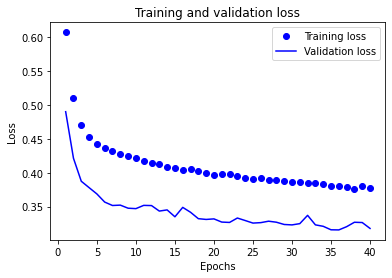

In [145]:
# Plot training and validation loss

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

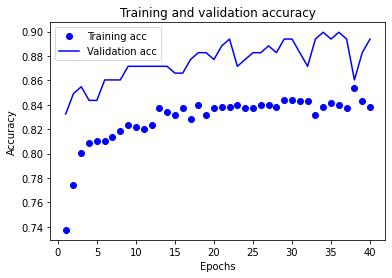

In [146]:
# Plot training and validation accuracy
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Predict values

Use the model to predict values, then create a new data frame with the proper labels.

Then export the predictions as a CSV named `submission.csv`

In [147]:
# Use Model to make predictions on the test data
predictions = model.predict(test_data_scaled)
print(predictions)

[[0.0367966 ]
 [0.3126946 ]
 [0.02518183]
 [0.10821897]
 [0.31129307]
 [0.14401066]
 [0.82602644]
 [0.22172618]
 [0.5545696 ]
 [0.06221914]
 [0.1063838 ]
 [0.20807746]
 [0.98939836]
 [0.08221605]
 [0.9745424 ]
 [0.8368623 ]
 [0.04778805]
 [0.2790376 ]
 [0.2718516 ]
 [0.2318072 ]
 [0.2100265 ]
 [0.49921378]
 [0.98461676]
 [0.39902228]
 [0.8501535 ]
 [0.03967732]
 [0.9757846 ]
 [0.25430942]
 [0.21967927]
 [0.12335065]
 [0.09653237]
 [0.09152165]
 [0.21030194]
 [0.24896368]
 [0.638508  ]
 [0.3222951 ]
 [0.3445127 ]
 [0.42919317]
 [0.10839877]
 [0.31035328]
 [0.15859815]
 [0.6573226 ]
 [0.09690845]
 [0.8586358 ]
 [0.9813975 ]
 [0.10629296]
 [0.27228576]
 [0.0487949 ]
 [0.9623962 ]
 [0.29744384]
 [0.4928097 ]
 [0.20045322]
 [0.76827383]
 [0.85488904]
 [0.17350852]
 [0.05877447]
 [0.10431716]
 [0.4522106 ]
 [0.08526886]
 [0.9853499 ]
 [0.12150118]
 [0.1067054 ]
 [0.11457083]
 [0.82026225]
 [0.17120275]
 [0.8870716 ]
 [0.8211993 ]
 [0.25950554]
 [0.5315159 ]
 [0.5246281 ]
 [0.82281065]
 [0.10

In [148]:
# Create a function to classify the predictions
def classify_predictions(predictions):
    predictions = predictions.reshape(-1,)
    tolerance = 0.5
    for i, prediction in enumerate(predictions):
        if prediction <= tolerance:
            predictions[i] = 0
        else:
            predictions[i] = 1
    
    return predictions

In [149]:
# Classify predictions using the classify function
predictions = classify_predictions(predictions)

# Insert the Survived predictions into the test_data dataframe
test_data.insert(loc = 0, column = "Survived", value = predictions)

# Export the data frame to a CSV
test_data["Survived"].to_csv("submission.csv")
print("Saved.")